# Importing the necessary Modules

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

## Running a few scripts to fetch the data from remote repo

https://github.com/datameet/covid19

In [2]:
os.system('./data_update.sh')
os.system('./fetch_data.sh')

0

In [3]:
f = 'data/mohfw.json'

data = pd.read_json(f) # reading the json file

df = pd.io.json.json_normalize(data['rows']) # getting data from the json file
# i know its a little convoluted here (found the solution after 40 minutes of searching :P)
#
#df['value.report_time'] = pd.to_datetime(df['value.report_time'])

## Setting up name of states

In [4]:
state_dict  = {
'ind':"India",
'ut':"Uttarakhand",
'ct':"Chhattisgarh",
'tr':"Tripura",
'pb':"Punjab",
'jh':"Jharkhand",
'or':"Odisha",
'ka':"Karnataka",
'mh':"Maharashtra",
'tn':"Tamil Nadu",
'as':"Assam",
'jk':"Jammu and Kashmir",
'mz':"Mizoram",
'rj':"Rajasthan",
'tg':"Telangana",
'wb':"West Bengal",
'up':"Uttar Pradesh",
'hr':"Haryana",
'br':"Bihar",
'py':"Puducherry",
'gj':"Gujarat",
'ar':"Arunachal Pradesh",
'la':"Ladakh",
'kl':"Kerala",
'ch':"Chandigarh",
'mp':"Madhya Pradesh",
'an':"Andaman and Nicobar Islands",
'ga':"Goa",
'dl':"Delhi",
'hp':"Himachal Pradesh",
'mn':"Manipur",
'ap':"Andhra Pradesh",
'nl':"Nagaland",
'ml':"Meghalaya",
'dn':"Dadar Nagar Haveli"
}

## Creating a class object to store and visualize data of a state

In [5]:
class State:
    """This class provides functions to filter, organise and visualize statewise data for Covid-19"""

    def __init__(self, df, state, db=None, st_abbr=None, time=None,
                 conf=None, cure=None, deth=None, growthrate=None,
                 conf_count=None,cure_count=None, deth_count=None,
                 daily_conf=None, daily_cure=None, daily_death=None,
                 fatality_rate=None,details=None):

        '''Initializing the values'''

        self.st_abbr = state
        self.state   = state_dict[state]

        self.db = df.groupby(pd.to_datetime(df['value.report_time']).dt.date).agg(
                                                {'value.confirmed': 'last',
                                                 'value.cured':'last',
                                                 'value.death':'last'}).reset_index()

        self.db['value.report_time'] = pd.to_datetime(self.db['value.report_time'],
                                                      dayfirst = True)

        self.db = self.db.sort_values(['value.report_time'])
        #self.db = self.db.resample('D').sum()

        self.time          = self.db['value.report_time']
        self.conf          = list(self.db['value.confirmed'])
        self.cure          = list(self.db['value.cured'])
        self.deth          = list(self.db['value.death'])

        self.conf_count    = max(self.conf)
        self.cure_count    = max(self.cure)
        self.deth_count    = max(self.deth)

        self.fatality_rate = self.deth_count*100/self.conf_count
        self.daily_conf    = [0]+[self.conf[i]-self.conf[i-1] for i in range(1,len(self.conf))]
        self.daily_cure    = [0]+[self.cure[i]-self.cure[i-1] for i in range(1,len(self.cure))]
        self.daily_death   = [0]+[self.deth[i]-self.deth[i-1] for i in range(1,len(self.deth))]

        try:
            self.growthrate = ((self.conf[-1]/self.conf[-2]) - 1)*100
        except:
            self.growthrate = 0

    def get_details(self):

        ''' get key details from the data'''

        self.details = {'State':self.state,
                        'code':self.st_abbr,
                        'confirmed':self.conf_count,
                        'cured':self.cure_count,
                        'deaths':self.deth_count,
                        'fatality_rate':self.fatality_rate
                    }
        return self.details

    def plot_summary(self,plot_flag=None,ylimit=None):
        'plotting the results in a multipanel plot'

        plt.style.use('seaborn')
        fig, ax = plt.subplots(3, 1,figsize=(9,8),sharex=True,
                            gridspec_kw={'height_ratios': [2.1, 2.4, 1]})

        'top panel showing counts vs time with a legend'
        '----------------------------------------------'
        ax[0].set_title('{} \n({})'.format(self.state.upper(),
                        max(self.time).date()),
                        fontsize=15)

        ax[0].plot(self.time, self.conf, 'C0-o',lw=5,ms=10,
                label='confirmed cases ({})'.format(self.conf_count))

        ax[0].plot(self.time, self.cure,'C1-p',lw=4,ms=10,
                label='recovered cases ({})'.format(self.cure_count))

        ax[0].plot(self.time, self.deth,'C2-v',alpha=.6,
                label='deaths ({})'.format(self.deth_count))

        ax[0].fill_between(self.time,self.cure,self.deth,facecolor='C1',alpha=0.2)

        ax[0].fill_between(self.time,self.deth,facecolor='C2',alpha=0.2,
                        label='fatality rate ({:0.2f}%)'.format(self.fatality_rate))

        ax[0].fill_between(self.time,self.conf,self.cure,facecolor='C0',alpha=0.1,
                        label='Growth rate ({:.2f}%)'.format(self.growthrate))

        #ax[0].set_xlabel('Date')
        ax[0].set_ylabel('Numbers')
#        ax[0].set_ylim(0, 12000)
        if ylimit is None:
            ax[0].set_ylim(0, self.conf_count*1.1)
        else:
            ax[0].set_ylim(0, ylimit)

        ax[0].legend(loc=2,fontsize=15,frameon=True,fancybox=True,
                    framealpha=.7,facecolor='white', borderpad=1)

        'middle panel with log scale of counts vs time'
        '----------------------------------------------'
        ax[1].set_title("Log scale")

        ax[1].plot(self.time,self.conf,'C0-o',lw=5,ms=10)

        ax[1].plot(self.time,self.cure,'C1-p',lw=4,ms=10)

        ax[1].plot(self.time,self.deth,'C2-v',alpha=.6)

        ax[1].fill_between(self.time,self.conf,self.cure,facecolor='C0',alpha=0.1)
        ax[1].fill_between(self.time,self.cure,self.deth,facecolor='C1',alpha=0.2)
        ax[1].fill_between(self.time,self.deth,facecolor='C2',alpha=0.2)

    #    ax[1].set_xlabel('Date')
        ax[1].set_ylabel('Numbers')
        ax[1].set_yscale('symlog')
        ax[1].set_yticks([10**i for i in range(7)])
        ax[1].set_yticklabels(['{:2d}'.format(10**i) for i in range(7)])
        ax[1].set_ylim(0,100000)


        'bottom panel showing daily counts'
        '----------------------------------------------'
        ax[2].set_title('Daily Cases')

        ax[2].bar(self.time, self.daily_conf,width=.5)

        xtik = pd.date_range(start='3/10/2020',
                             end=pd.to_datetime('today')+pd.Timedelta('7 days'),
                             freq='7D')
        ax[2].set_xticks(xtik)
        ax[2].set_xticklabels(xtik.strftime('%B %d'))
        ax[2].set_xlim('2020-03-08',pd.to_datetime('today')+pd.Timedelta('5 days'))
        ax[2].set_xlabel('Date')

        fig.tight_layout()

        if plot_flag==None:
            plt.savefig(f'plots/{self.st_abbr}.png',dpi=150)
        elif plot_flag==1:
            plt.savefig(f't_plot/{self.st_abbr}_{max(self.time).date()}.png',dpi=150)
        else:
            pass

        #plt.show()
        plt.close()

In [6]:
states_list = list(set(df['value.state']))

state_objects = []

for st in states_list:
    state_db  = df[(df['value.state'] == st)]
    state_obj = State(state_db,st) # creating an object for each individual state
    name      = {'object':state_obj} # putting that into a dictionary
    detail    = state_obj.get_details() # this returns a dictionary with details like cases, counts etc..
    detail.update(name) # merging both the dictionaries

    state_obj.plot_summary() #creating plot for each state

    state_objects.append(detail) # appending the dictionaries into a list

/home/jishnu/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


In [7]:
db = pd.DataFrame(state_objects) # creating a dataframe from the list of dictionaries
db = db.sort_values(['confirmed']) # sorting by confirmed cases
db['Total'] = db.confirmed+db.cured+db.deaths

India = {
'cases':sum(db.confirmed),
'cured':sum(db.cured),
'death':sum(db.deaths)
}

## Creating a function to create a bar plot

In [8]:
def plot_bar(db):
    '''create a stacked horizontal barplot from states' data'''

    db['cases'] = db.confirmed-db.cured-db.deaths

#    cases  = list(db.cases)
    cured  = list(db.cured)
    death  = list(db.deaths)
    tot    = list(db.confirmed)

    plt.style.use('seaborn')
    ax = db[['State','deaths', 'cases', 'cured']].plot(kind='barh',
                                       figsize=(12,16), width=.7, fontsize=13,
                                       color=['C2', 'C0', 'C1'], stacked=True)
    for i in range(len(tot)):
        ax.text(tot[i]+20,i-.1,'{:<4d}'.format(tot[i]), fontsize=12)
        ax.text(tot[i]+350,i+.05,'{}'.format(cured[i]), fontsize=10, color='g')
        ax.text(tot[i]+350,i-.25,'{}'.format(death[i]), fontsize=9, color='r')

    ax.set_title('India \n(Cases:{}, Cured:{}, deaths:{})'.format(*list(India.values())),
                         fontsize=14)
    ax.set_xlim(0,max(tot)+800)
    ax.set_alpha(0.8)

    ax.set_yticklabels(list(db.State))

    ax.legend(loc=5,fontsize=12,frameon=True,fancybox=True,
             framealpha=.7,facecolor='white', borderpad=1)

    plt.tight_layout()
    plt.savefig(f'plots/summary.png',dpi=150)
    plt.show()
    plt.close()

/home/jishnu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


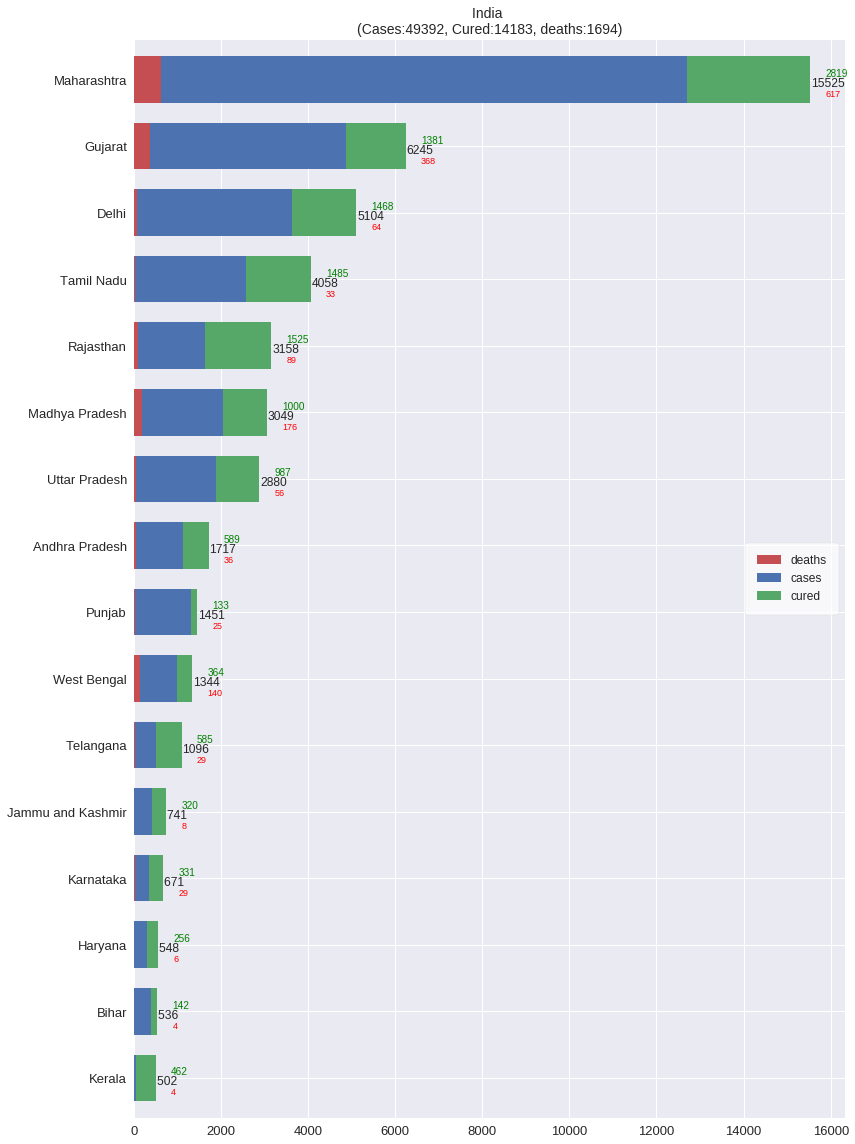

In [9]:
db5 = db[(db['confirmed'] >= 200)]
plot_bar(db5)

In [10]:
conf_ts = pd.read_csv('data/confirmed.csv',names=['value.report_time','value.confirmed'])
cure_ts = pd.read_csv('data/cured.csv'    ,names=['value.report_time','value.cured'])
deth_ts = pd.read_csv('data/death.csv'    ,names=['value.report_time','value.death'])

In [11]:
ind = conf_ts
ind['value.report_time'] = pd.to_datetime(ind['value.report_time'])

ind['value.cured'],ind['value.death'] = cure_ts['value.cured'],deth_ts['value.death']
ind['value.state'] = ['ind' for i in range(len(ind['value.cured']))]

daily = ind.groupby(ind['value.report_time'].dt.date).agg({
                                         'value.confirmed': 'last',
                                         'value.cured':'last',
                                         'value.death':'last'
                                         }).reset_index()
daily.columns = ['Date','Infected','Cured','Dead']
daily.to_csv('data/time_series.csv',sep=',',index=False)

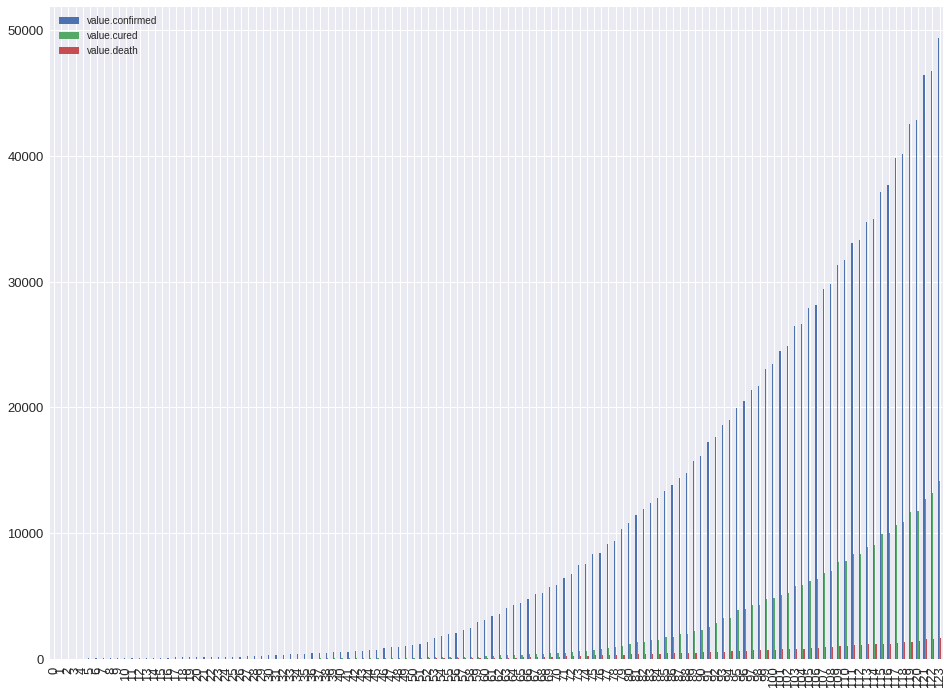

In [12]:
ax = ind[['value.confirmed', 'value.cured', 'value.death']].plot(kind='bar',figsize=(16,12), 
                                                                 width=.5, fontsize=13,
                                                                 color=['C0', 'C1', 'C2'])

In [13]:
IN = State(ind,'ind')
IN.get_details()
IN.plot_summary()

In [14]:
db = pd.DataFrame(state_objects) # creating a dataframe from the list of dictionaries
db = db.sort_values(['confirmed']) # sorting by confirmed cases
db['Total'] = db.confirmed+db.cured+db.deaths

states_list = list(db.code)[::-1]

with open('README.md','r') as intro:
    with open('Intro.md','w') as outfile:
        outfile.write(intro.read())
        for state in states_list:
            st     = state
            state  = state_dict[state]
            outfile.write(f'# {state} \n\n\centering\n\n![](plots/{st}.png){{width=70%}}\n\n\n')
    #            outfile.write(f'# {state} \n\n\n![](plots/{st}.png)\n\n\n')

os.system('pandoc Intro.md -t beamer -o report.pdf')



0

In [15]:
#%%
#'''global time series data'''
#URL_DATASET = r'https://raw.githubusercontent.com/datasets/covid-19/master/data/countries-aggregated.csv'
#gdf = pd.read_csv(URL_DATASET)